In [1]:
# !pip install -q transformers
#!pip install -U albumentations
# !pip install torchsummary
# !pip install torchinfo

In [10]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, ToTensor
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader,random_split,Subset
from transformers import AutoFeatureExtractor, ResNetForImageClassification
import numpy as np
from tqdm import tqdm
import datetime
import albumentations as A
import albumentations.pytorch as ATorch
from albumentations.augmentations.geometric.transforms import PadIfNeeded
from albumentations.augmentations.transforms import Normalize
from albumentations.augmentations.geometric.resize import Res
import matplotlib.pyplot as plt
import cv2
import gc
import random
import os
import pickle

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [12]:
train_df = pd.read_csv("project_data/train.csv")

def get_frac_data_from_patient(target):
    patient_index = list(image_data.class_to_idx.values()).index(target)
    patient_name = list(image_data.class_to_idx.keys())[patient_index]
    row_for_pt = train_df[train_df["StudyInstanceUID"] == patient_name]
    return row_for_pt.iloc[:,1:].values


path = "project_data/project_analysis/sag"
image_data = ImageFolder(root=path, target_transform= get_frac_data_from_patient)
print(f"{len(image_data)} Samples")


16952 Samples


In [13]:
def get_image_shapes(dataset):
    tensor_t = ToTensor()
    shapes = []
    for sample in dataset:
        shapes.append(sample[0].size)
    return torch.Tensor(shapes)

In [14]:
def get_image_sequence(dataset):
    i = 0
    img_data_list = []
    for sample in random.sample(range(len(dataset)), len(dataset) // 4):
        # print(sample[0])
        img = dataset[sample]
        img_data = img[0].getdata()
        img_data_list.append(img_data)
        i += 1
        if i % 1000 == 0:
            print(i)
    return np.concatenate(img_data_list, axis=0) / 255

In [ ]:
stat_file = 'image_stats.pickle'

if not os.path.exists(stat_file):
    print("Getting Shapes")
    shapes = get_image_shapes(image_data)
    print(f"Max Height: {torch.max(shapes[:,0])}, Max Width: {torch.max(shapes[:,1])}")
    print("Getting mean and std")
    data = get_image_sequence(image_data)
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    print(f"mean: {mean}, std:{std}")
    dataset_stats = {"mean": mean, "std": std, "shapes": shapes}
    with open(stat_file, 'wb') as f:
        pickle.dump(dataset_stats, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(stat_file, 'rb') as handle:
        dataset_stats = pickle.load(handle)

Getting Shapes
Max Height: 768.0, Max Width: 1082.0
Getting mean and std
1000
2000
3000
4000


In [ ]:
print(dataset_stats['mean'])

In [16]:
class ImageDataset(Dataset):
    def __init__(self, image_dataset, transform=None):
        self.image_data = image_dataset
        self.transform = transform

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        image, label = self.image_data[idx]
        image = np.array(image)
        label = label.astype(np.float32)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, np.squeeze(label)

In [33]:
base_augmentations = A.Compose([
    PadIfNeeded(min_height=int(torch.max(dataset_stats["shapes"][:,0]).item()), min_width=int(torch.max(dataset_stats["shapes"][:,1]).item())),
    A.Normalize(mean=dataset_stats["mean"].tolist(), std=dataset_stats["std"].tolist(), max_pixel_value=1),
    ATorch.transforms.ToTensorV2(),
])
    
image_dataset = ImageDataset(image_data, base_augmentations)

In [9]:
### Model Declaration

class ResNetForMultiClassPrediction(nn.Module):
    def __init__(self):
        super(ResNetForMultiClassPrediction, self).__init__()
        self.resnet = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=8, ignore_mismatched_sizes=True)
        # Add Sigmoid for output between 0 and 1
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.resnet(x).logits
        x = self.sigmoid(x)
        return x

model = ResNetForMultiClassPrediction()
model.to(device)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([8, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ResNetForMultiClassPrediction(
  (resnet): ResNetForImageClassification(
    (resnet): ResNetModel(
      (embedder): ResNetEmbeddings(
        (embedder): ResNetConvLayer(
          (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
        )
        (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (encoder): ResNetEncoder(
        (stages): ModuleList(
          (0): ResNetStage(
            (layers): Sequential(
              (0): ResNetBottleNeckLayer(
                (shortcut): ResNetShortCut(
                  (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )
                (layer): Sequential(

In [10]:
# Train and Test functions (Taken from HW3 of CS7150 HWs)

# Train Function
def train_model(model, train_loader, device, loss_fn, optimizer):
    model.train()
    # Initiate a loss monitor
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning and not supervised classification)
    for i, (images, labels) in enumerate(train_loader): # the variable `labels` will be used for customised training
        # reshape input
        if (i % (len(train_loader) // 10) == 0):
            print(f"Completed {i} batches")
        optimizer.zero_grad()
        model.zero_grad()
        images = images.float()
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        loss = loss_fn(predicted, labels)
        # Backward pass (back propagation)
        loss.backward()
        optimizer.step()       
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss), train_loss

# Testing Function
def test_model(model, test_loader, device, loss_fn, input_dim=(-1,1,28,28)):
    # Set evaluation mode for encoder and decoder
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        predicted = []
        actual = []
        for i, (images, labels) in enumerate(test_loader):
            # reshape input
            # images = torch.reshape(images,input_dim)
            if (i % (len(val_loader) // 5) == 0):
                print(f"Completed {i} batches")
            images = images.float()
            images = images.to(device)
            labels = labels.to(device)
            ## predict the label
            pred = model(images)
            # Append the network output and the original image to the lists
            predicted.append(pred.cpu())
            actual.append(labels.cpu())
        # Create a single tensor with all the values in the lists
        predicted = torch.cat(predicted)
        actual = torch.cat(actual) 
        # Evaluate global loss
        val_loss = loss_fn(predicted, actual)
    return val_loss.data, (predicted, actual)

In [11]:
### MODEL HYPERPARAMS
loss_fn = torch.nn.BCELoss()

lr= 0.5
num_epochs = 25
batch_size = 20
optim = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=2*10**-5, momentum=0.9)
lr_warmup_decay = 0.01
lr_warmup_epochs = 5


main_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=num_epochs - lr_warmup_epochs)
warmup_lr_scheduler = torch.optim.lr_scheduler.LinearLR(optim, start_factor=lr_warmup_decay, total_iters=lr_warmup_epochs)
lr_scheduler = torch.optim.lr_scheduler.SequentialLR(optim, schedulers=[warmup_lr_scheduler, main_lr_scheduler], milestones=[lr_warmup_epochs])
### DATA PREPARATION
n_train_samples = len(image_data)
val_split = .15


train_data, val_data = random_split(image_dataset, [int(n_train_samples*(1-val_split))+1, int(n_train_samples*val_split)])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle=True, num_workers=0)

In [13]:

### Pytorch Native TRAIN LOOP

print('ResNet training started')
history = {'train_loss':[],'val_loss':[], "batch_train_loss": []}
start_time = datetime.datetime.now()
folder_date = start_time.strftime("%Y_%m_%d_%H_%M_%S")

model_ckpt_path = f"ResNet_model_train_{folder_date}"

if not os.path.exists(f"model_ckpts/{model_ckpt_path}"):
    os.mkdir(f"model_ckpts/{model_ckpt_path}")
    
best_val_loss = 10**10

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    epoch_start_time = datetime.datetime.now()
    ### Training 
    print("Training Started")
    epoch_train_loss, batch_train_loss = train_model(
        model=model,
        train_loader=train_loader,
        device=device,
        loss_fn=loss_fn,
        optimizer=optim)
    print("Validation Started")
    ### Validation  (use the testing function)
    val_loss, predictions = test_model(
        model=model,
        test_loader=val_loader,
        device=device,
        loss_fn=loss_fn)
    lr_scheduler.step()
    # Print Losses 
    if (val_loss < best_val_loss):
        print(f"New Best Model with loss {val_loss}")
        torch.save(model.state_dict(), f"model_ckpts/{model_ckpt_path}/{epoch}_model_loss_{val_loss}.ckpt")
        best_val_loss = val_loss
    print(f'Epoch {epoch+1}/{num_epochs} : train loss {epoch_train_loss:.3f} \t val loss {val_loss:.3f}')
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(val_loss)
    history['batch_train_loss'].extend(batch_train_loss)
    with open(f"model_ckpts/{model_ckpt_path}/epoch_{epoch}_model_results.pickle", 'wb') as f:
        pickle.dump(history, f)
    print(f'Epoch {epoch} training done in {(datetime.datetime.now()-epoch_start_time).total_seconds():.3f} seconds!')
    
with open(f"model_ckpts/{model_ckpt_path}/model_results.pickle", 'wb') as f:
    pickle.dump(history, f)
    
print(f'ResNet training done in {(datetime.datetime.now()-start_time).total_seconds():.3f} seconds!')

ResNet training started
Epoch: 0
Training Started
Completed 0 batches
Completed 72 batches
Completed 144 batches
Completed 216 batches
Completed 288 batches
Completed 360 batches
Completed 432 batches
Completed 504 batches
Completed 576 batches
Completed 648 batches
Completed 720 batches
Validation Started
Completed 0 batches
Completed 25 batches
Completed 50 batches
Completed 75 batches
Completed 100 batches
Completed 125 batches
New Best Model with loss 0.36477890610694885
Epoch 1/25 : train loss 0.382 	 val loss 0.365
Epoch 0 training done in 1164.667 seconds!
Epoch: 1
Training Started
Completed 0 batches
Completed 72 batches
Completed 144 batches
Completed 216 batches
Completed 288 batches
Completed 360 batches
Completed 432 batches
Completed 504 batches
Completed 576 batches
Completed 648 batches
Completed 720 batches
Validation Started
Completed 0 batches
Completed 25 batches
Completed 50 batches
Completed 75 batches
Completed 100 batches
Completed 125 batches
New Best Model with

/home/lachyankar.a/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


New Best Model with loss 0.2598411440849304
Epoch 5/25 : train loss 0.245 	 val loss 0.260
Epoch 4 training done in 1129.332 seconds!
Epoch: 5
Training Started
Completed 0 batches
Completed 72 batches
Completed 144 batches
Completed 216 batches
Completed 288 batches
Completed 360 batches
Completed 432 batches
Completed 504 batches
Completed 576 batches
Completed 648 batches
Completed 720 batches
Validation Started
Completed 0 batches
Completed 25 batches
Completed 50 batches
Completed 75 batches
Completed 100 batches
Completed 125 batches
New Best Model with loss 0.2135738730430603
Epoch 6/25 : train loss 0.182 	 val loss 0.214
Epoch 5 training done in 1189.023 seconds!
Epoch: 6
Training Started
Completed 0 batches
Completed 72 batches
Completed 144 batches
Completed 216 batches
Completed 288 batches
Completed 360 batches
Completed 432 batches
Completed 504 batches
Completed 576 batches
Completed 648 batches
Completed 720 batches
Validation Started
Completed 0 batches
Completed 25 batc

KeyboardInterrupt: 

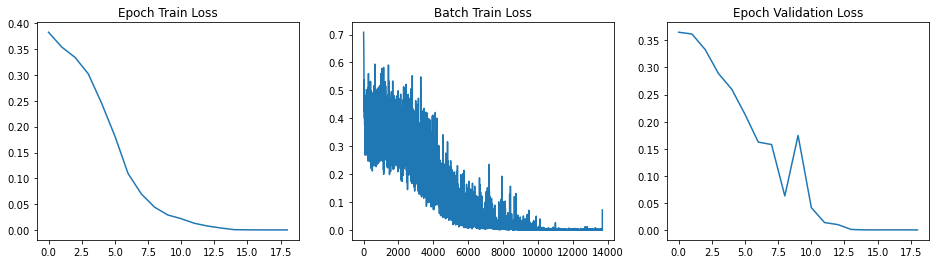

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16,4))

ax1.plot(history['train_loss'])
ax1.title.set_text('Epoch Train Loss')

ax2.plot(history['batch_train_loss'])
ax2.title.set_text('Batch Train Loss')

ax3.plot(history['val_loss'])
ax3.title.set_text('Epoch Validation Loss')

plt.savefig('resnet_loss_graphs.png')

In [19]:
path = "project_data/project_analysis/sag_test"
image_data_test = ImageFolder(root=path, target_transform=lambda x: np.array([1,1,0,0,0,0,0,0]))
print(f"{len(image_data_test)} Samples")

image_dataset_test = ImageDataset(image_data_test, base_augmentations)

test_loader = torch.utils.data.DataLoader(image_dataset_test, batch_size=batch_size,shuffle=False, num_workers=0)

model = ResNetForMultiClassPrediction()
model.load_state_dict(torch.load('model_ckpts/ResNet_model_train_2022_12_04_16_39_28/18_model_loss_0.0009133503190241754.ckpt'))
model.to(device)

test_loss, predictions = test_model(
    model=model,
    test_loader=test_loader,
    device=device,
    loss_fn=loss_fn)

303 Samples


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([8, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed 0 batches


In [20]:
pred_arr = predictions[0].numpy()
actual_arr = predictions[1].numpy()
thresholded_pred = np.where(pred_arr > 0.5, 1, 0)
correct = (thresholded_pred == actual_arr).all(axis=1).nonzero()[0]

for i,index in enumerate(correct):
    im = image_data_test[index][0]
    im.save(f'correct_resnet_{i}.png')

In [21]:
print(thresholded_pred)

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
val_loss, predictions = test_model(
    model=model,
    test_loader=val_loader,
    device=device,
    loss_fn=loss_fn)

Completed 0 batches
Completed 25 batches
Completed 50 batches
Completed 75 batches


In [ ]:
pred_arr = predictions[0].numpy()
actual_arr = predictions[1].numpy()
thresholded_pred = np.where(pred_arr > 0.5, 1, 0)
correct = (thresholded_pred == actual_arr).all(axis=1).nonzero()[0]

for i,index in enumerate(correct):
    im = image_data_test[index][0]
    im.save(f'correct_resnet_val_{i}.png')